In [1]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

%matplotlib inline

In [2]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
# - import numpy.linalg with a shorter name
import numpy.linalg as npl

In [4]:
# - make numpy print out values in less verbose form
np.set_printoptions(suppress=True, precision=4)

## Reslicing between spaces using affines

In the current directory, we have a BOLD (4D image) and a structural image for the same subject:

* BOLD image : `ds114_sub009_t2r1.nii`;
* structural image : `ds114_sub009_highres.nii`.

They have different orientations and voxel sizes.

Confirm this by loading each image, and showing the:

* image shape
* image affine from the header

In [5]:
# Load structural and BOLD image
# Print image data shape
# Print affine from header
import nibabel as nib
bold_img = nib.load('data/ds114_sub009_t2r1.nii')
print('BOLD')
print(bold_img.shape)
print(bold_img.affine)
structural_img = nib.load('data/ds114_sub009_highres.nii')
print('Structural')
print(structural_img.shape)
structural_img.affine

BOLD
(64, 64, 30, 173)
[[  -4.        0.        0.      124.244 ]
 [   0.        3.9345    0.7207 -103.4497]
 [   0.       -0.7207    3.9346  -33.4929]
 [   0.        0.        0.        1.    ]]
Structural
(256, 156, 256)


/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


array([[   0.9989,   -0.0605,    0.0109, -129.8257],
       [   0.0427,    1.263 ,    0.2336, -119.0906],
       [  -0.0215,   -0.3028,    0.9723, -143.4178],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

We know this BOLD image now.  It has a bad first volume.  Load the BOLD data, drop the first volume, and make a new volume that is the mean of the rest of the BOLD volumes across time.  Plot an example slice from the mean volume.

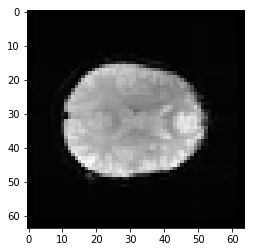

In [6]:
# Load BOLD image data.  Drop first volume.  Make mean volume
# Plot an example slice from the mean volume
bold_data = bold_img.get_data()
mean_vol = bold_data[..., 1:].mean(axis=-1)
plt.imshow(mean_vol[:, :, 14])

Load the structural data, plot an example slice:

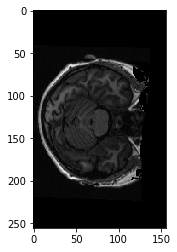

In [7]:
# Load structural data, plot example slice
structural_data = structural_img.get_data()
plt.imshow(structural_data[:, :, 127])

Now we are going to reslice the anatomical to match the mean functional volume.

Remember pull resampling?   We are going to need the transform that maps a coordinate in the mean functional volume, to the corresponding coordinate in the structural volume. 

In order to do this, we need:

* The affine mapping from mean functional voxel coordinates to mm space (`mean_vox2mm`);
* The affine mapping from mm space to structural voxel coordinates (`mm2struct_vox`).

We combine these by matrix multiplication (*from right to left!*) to give `mean_vox2struct_vox`:

In [8]:
# Get `mean_vox2mm` mapping
# Get `mm2struct_vox` mapping
# Calculate `mean_vox2struct_vox`
mean_vox2mm = bold_img.affine
mm2struct_vox = npl.inv(structural_img.affine)
mean_vox2struct_vox = mm2struct_vox.dot(mean_vox2mm)
mean_vox2struct_vox

array([[ -3.9954,   0.1836,  -0.0536, 252.0885],
       [  0.1432,   3.0686,  -0.1663, -17.1005],
       [ -0.0436,   0.2185,   3.9938, 113.2972],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

Split this affine matrix up into its component 3x3 `M` matrix and the 3 element translation vector:

In [9]:
# Split `mean_vox2struct_vox` into 3x3 transformation, 3 element translation
M = mean_vox2struct_vox[:3, :3]
T = mean_vox2struct_vox[:3, 3]
M, T

(array([[-3.9954,  0.1836, -0.0536],
        [ 0.1432,  3.0686, -0.1663],
        [-0.0436,  0.2185,  3.9938]]), array([252.0885, -17.1005, 113.2972]))

Now we can use `affine_transform` to make a new copy of the structural image, resampled into the voxel coordinates of the mean functional image:

In [10]:
# Use affine_transform and the tranformation components to resample structural to functional
from scipy.ndimage import affine_transform
struct_in_mean_space = affine_transform(structural_data, M, T, mean_vol.shape, order=1)
struct_in_mean_space.shape

(64, 64, 30)

Use `subplots` to display and example slice from the mean image and the resliced structural side by side:

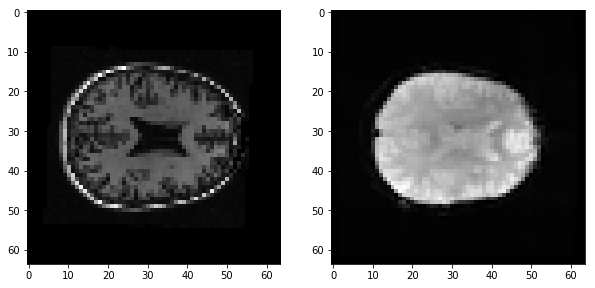

In [11]:
# Display example slice from mean vol and resliced structural side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(struct_in_mean_space[:, :, 14])
axes[1].imshow(mean_vol[:, :, 14])

Now let's go in the opposite direction.

We are going to resample the mean functional volume into the voxel space of the structural volume.

We now need the affine transformation from voxel coordinates in the structural to voxel coordinates in the mean functional volume - call this `struct_vox2mean_vox`:

In [12]:
# Get affine transformation `struct_vox2mean_vox`
struct_vox2mean_vox = npl.inv(mean_vox2struct_vox)
struct_vox2mean_vox

array([[ -0.2497,   0.0151,  -0.0027,  63.5174],
       [  0.0115,   0.3242,   0.0137,   1.1053],
       [ -0.0034,  -0.0176,   0.2496, -27.7359],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

Use the contents of `struct_vox2mean_vox` to reslice the mean functional to the structural voxel space:

In [13]:
# Reslice mean functional to structural voxel space
M, T = nib.affines.to_matvec(struct_vox2mean_vox)
mean_in_struct_space = affine_transform(mean_vol, M, T, structural_data.shape, order=1)

Display example slice for resliced mean functional side by side with structural

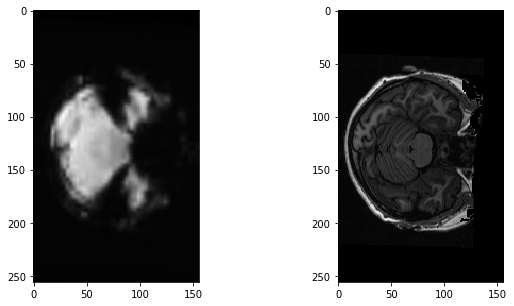

In [14]:
# Display example slices for resliced mean and structural
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mean_in_struct_space[:, :, 127])
axes[1].imshow(structural_data[:, :, 127])